In [1]:
import os
import pickle

pdf_path = "data/ps.pdf"
cache_path = "data/ps_documents.pkl"

if os.path.exists(cache_path):
    with open(cache_path, "rb") as f:
        documents = pickle.load(f)
    print("Loaded documents from cache.")
else:
    from langchain_community.document_loaders import PyPDFLoader
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()
    with open(cache_path, "wb") as f:
        pickle.dump(documents, f)
    print("Loaded documents from PDF and cached.")


Loaded documents from cache.


In [10]:
documents

[Document(metadata={'producer': 'PDF Candy', 'creator': 'PyPDF', 'creationdate': '2020-03-30T07:09:46+00:00', 'moddate': '2020-03-30T07:09:46+00:00', 'source': 'data/ps.pdf', 'total_pages': 365, 'page': 0, 'page_label': '1'}, page_content=''),
 Document(metadata={'producer': 'PDF Candy', 'creator': 'PyPDF', 'creationdate': '2020-03-30T07:09:46+00:00', 'moddate': '2020-03-30T07:09:46+00:00', 'source': 'data/ps.pdf', 'total_pages': 365, 'page': 1, 'page_label': '2'}, page_content='Practical\tTime\tSeries\tAnalysis\nPrediction\twith\tStatistics\tand\t\nMachine\tLearning\nAileen\tNielsen'),
 Document(metadata={'producer': 'PDF Candy', 'creator': 'PyPDF', 'creationdate': '2020-03-30T07:09:46+00:00', 'moddate': '2020-03-30T07:09:46+00:00', 'source': 'data/ps.pdf', 'total_pages': 365, 'page': 2, 'page_label': '3'}, page_content='Practical\tTime\tSeries\tAnalysis\nby\t\nAileen\t\nNielsen\nCopyright\t©\t2020\tAileen\tNielsen.\tAll\trights\treserved.\nPrinted\tin\tthe\tUnited\tStates\tof\tAmeric

In [2]:
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    CharacterTextSplitter,
    TokenTextSplitter,
    NLTKTextSplitter,
    SpacyTextSplitter,
    MarkdownTextSplitter
)

# Optional: NLTK & SpaCy setup if we plan to use them
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")

import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")


def split_recursive(documents, chunk_size=500, chunk_overlap=50):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""]
    )
    return splitter.split_documents(documents)


def split_character(documents, chunk_size=500, chunk_overlap=50):
    splitter = CharacterTextSplitter(
        separator="\n",
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    return splitter.split_documents(documents)


def split_token(documents, chunk_size=200, chunk_overlap=20):
    splitter = TokenTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    return splitter.split_documents(documents)


def split_nltk(documents):
    splitter = NLTKTextSplitter()
    return splitter.split_documents(documents)


def split_spacy(documents):
    splitter = SpacyTextSplitter(pipeline="en_core_web_sm")
    return splitter.split_documents(documents)



def split_documents(method, documents, **kwargs):
    """
    Wrapper to call the appropriate split function.
    method: str, one of ['recursive', 'character', 'token', 'nltk', 'spacy']
    documents: list of documents to split
    kwargs: additional arguments for the splitter functions
    """
    if method == "recursive":
        return split_recursive(documents, **kwargs)
    elif method == "character":
        return split_character(documents, **kwargs)
    elif method == "token":
        return split_token(documents, **kwargs)
    elif method == "nltk":
        return split_nltk(documents)
    elif method == "spacy":
        return split_spacy(documents)
    else:
        raise ValueError(f"Unknown split method: {method}")




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CORP_rigia_$\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\CORP_rigia_$\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


| Reason                                                         | Impact                      |
|----------------------------------------------------------------|-----------------------------|
| Sentence-based splitters (NLTK/Spacy) don't chunk aggressively | ➤ Fewer, longer chunks      |
| Recursive/Token-based splitters aim for fixed size             | ➤ Many small chunks         |
| Tokenizer-based splitting is model-aware (good for OpenAI)     | ➤ Slower but token-accurate |


**Pre-Processing of chunks**

| Step                  | Purpose                             | Tool / Method                        |
|-----------------------|-------------------------------------|--------------------------------------|
| `.strip()`            | Remove leading/trailing whitespace  | Python built-in                      |
| Remove empty chunks   | Avoid noise in retrieval/similarity | `if not chunk.page_content.strip()`  |
| Normalize whitespace  | Collapse multiple newlines or tabs  | `re.sub(r"\s+", " ", text)`          |
| Unicode normalization | Clean weird characters from PDFs    | `unicodedata.normalize("NFKC", ...)` |


In [3]:
import re
import unicodedata

def preprocess_chunk_text(text):
    """
    General-purpose preprocessing for text chunks.

    Steps:
    - Strip leading/trailing whitespace
    - Normalize unicode characters
    - Collapse multiple spaces/newlines/tabs
    - Remove non-printable control characters
    """
    if not isinstance(text, str):
        return ""

    # Strip leading/trailing whitespace
    text = text.strip()

    # Normalize unicode characters (e.g., fancy quotes → plain quotes)
    text = unicodedata.normalize("NFKC", text)

    # Remove control characters (non-printable)
    text = re.sub(r"[\x00-\x1F\x7F]", "", text)

    # Collapse multiple whitespace characters into a single space
    text = re.sub(r"\s+", " ", text)

    return text



def get_chunk_statistics(chunks, tokenizer=None):
    """
    Returns statistics about the given chunks.
    If tokenizer is provided, also returns token-based stats.
    """
    import numpy as np

    char_lengths = [len(chunk.page_content) for chunk in chunks]
    stats = {
        "num_chunks": len(chunks),
        "min_chars": int(np.min(char_lengths)) if char_lengths else 0,
        "max_chars": int(np.max(char_lengths)) if char_lengths else 0,
        "mean_chars": float(np.mean(char_lengths)) if char_lengths else 0,
        "median_chars": float(np.median(char_lengths)) if char_lengths else 0,
        "std_chars": float(np.std(char_lengths)) if char_lengths else 0,
    }

    if tokenizer is not None:
        try:
            token_counts = [len(tokenizer.encode(chunk.page_content)) for chunk in chunks]
        except AttributeError:
            token_counts = [len(tokenizer.tokenize(chunk.page_content)) for chunk in chunks]
        stats.update({
            "min_tokens": int(np.min(token_counts)) if token_counts else 0,
            "max_tokens": int(np.max(token_counts)) if token_counts else 0,
            "mean_tokens": float(np.mean(token_counts)) if token_counts else 0,
            "median_tokens": float(np.median(token_counts)) if token_counts else 0,
            "std_tokens": float(np.std(token_counts)) if token_counts else 0,
        })

    return stats




import matplotlib.pyplot as plt
import seaborn as sns

def visualize_chunk_distributions(chunks, tokenizer=None, method_name=None):
    """
    Visualize chunk length (character count) and token count distributions.
    If tokenizer is provided, it should have a .encode() or .tokenize() method.
    method_name: Optional string to display in chart titles.
    """
    # Character lengths
    char_lengths = [len(chunk.page_content) for chunk in chunks]

    # Token counts
    if tokenizer is not None:
        try:
            token_counts = [len(tokenizer.encode(chunk.page_content)) for chunk in chunks]
        except AttributeError:
            token_counts = [len(tokenizer.tokenize(chunk.page_content)) for chunk in chunks]
    else:
        token_counts = None

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    title = "Chunk Length Distribution (Characters)"
    if method_name:
        title += f" - {method_name}"
    sns.histplot(char_lengths, bins=30, kde=True)
    plt.title(title)
    plt.xlabel("Characters")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    title = "Chunk Length Distribution (Tokens)"
    if method_name:
        title += f" - {method_name}"
    if token_counts is not None:
        sns.histplot(token_counts, bins=30, kde=True, color="darkgreen")
        plt.title(title)
        plt.xlabel("Tokens")
        plt.ylabel("Count")
    else:
        plt.text(0.5, 0.5, "No tokenizer provided", ha='center', va='center', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()



import matplotlib.pyplot as plt
import seaborn as sns

def plot_chunk_similarities(df, method_name=None):
    """
    Plots a time series of similarity_to_next_chunk from the DataFrame output of chunk_consecutive_cosine_similarities.
    """
    plt.figure(figsize=(12, 5))
    title = "Consecutive Chunk Cosine Similarities"
    if method_name:
        title += f" - {method_name}"
    sns.lineplot(data=df, x="chunk_number", y="similarity_to_next_chunk")
    plt.title(title)
    plt.xlabel("Chunk Number")
    plt.ylabel("Cosine Similarity to Next Chunk")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [ ]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def resplit_oversized_chunks(
    chunks,
    max_tokens=1000,
    model_name="gpt-3.5-turbo",
    chunk_size=4000,
    chunk_overlap=200
):
    """
    Re-splits chunks that exceed the token limit using RecursiveCharacterTextSplitter.

    Args:
        chunks: List of LangChain Document objects.
        max_tokens: Max allowed tokens per chunk.
        model_name: Model name used to get tokenizer (default: "gpt-3.5-turbo").
        chunk_size: Character length for re-splitting oversized chunks.
        chunk_overlap: Overlap (in characters) when re-splitting.

    Returns:
        List of Document chunks within token limit.
    """
    enc = tiktoken.encoding_for_model(model_name)
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    final_chunks = []
    for chunk in chunks:
        if len(enc.encode(chunk.page_content)) <= max_tokens:
            final_chunks.append(chunk)
        else:
            final_chunks.extend(splitter.split_documents([chunk]))

    return final_chunks



import tiktoken  # For OpenAI tokenizer

def filter_chunks_by_token_length(chunks, min_tokens=50, model_name="gpt-3.5-turbo"):
    """
    Filters chunks based on token length using the tiktoken tokenizer.

    Args:
        chunks: List of LangChain Document objects
        min_tokens: Minimum token length to keep
        model_name: Tokenizer encoding (e.g., 'cl100k_base' for OpenAI embedding models)

    Returns:
        List of filtered Document chunks
    """
    enc = tiktoken.encoding_for_model(model_name)
    filtered = []
    for chunk in chunks:
        token_len = len(enc.encode(chunk.page_content))
        if min_tokens <= token_len:
            filtered.append(chunk)
    return filtered


import tiktoken

def clean_and_prepare_chunks(
    documents,
    method="nltk",
    min_tokens=50,
    max_tokens=1000,
    model_name="gpt-3.5-turbo",
    chunk_size=4000,
    chunk_overlap=200,
    preprocess=True
):
    """
    Splits, re-splits, optionally preprocesses, and filters chunks.

    Args:
        documents: List of LangChain Document objects.
        method: Splitter method name ('nltk', 'spacy', 'recursive', etc.).
        min_tokens: Minimum tokens required to keep a chunk.
        max_tokens: Maximum token limit per chunk.
        model_name: Tokenizer model name (e.g., 'gpt-3.5-turbo').
        chunk_size: Character chunk size for re-splitting.
        chunk_overlap: Character overlap for re-splitting.
        preprocess: If True, cleans chunk text before filtering.

    Returns:
        Filtered list of Document chunks.
    """
    # Step 1: Split documents using selected method
    chunks = split_documents(method, documents)

    # Step 2: Re-split any oversized chunks
    resplit = resplit_oversized_chunks(
        chunks,
        max_tokens=max_tokens,
        model_name=model_name,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )

    print(f"[INFO] Split and re-split produced {len(resplit)} chunks.")

    # Step 3: Preprocess each chunk's text if enabled
    if preprocess:
        for chunk in resplit:
            chunk.page_content = preprocess_chunk_text(chunk.page_content)
        print(f"[INFO] Preprocessed {len(resplit)} chunks.")

    # Step 4: Filter by token length
    before_filter = len(resplit)
    filtered = filter_chunks_by_token_length(
        resplit,
        min_tokens=min_tokens,
        model_name=model_name
    )
    after_filter = len(filtered)

    print(f"[INFO] Filtered out {before_filter - after_filter} chunks; {after_filter} remaining.")

    return filtered





import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Ensure stopwords are downloaded
nltk.download('stopwords')
from nltk.corpus import stopwords

def preprocess_for_similarity(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

def cosine_similarity_chunks(chunk1, chunk2):
    """
    Compute the cosine similarity between two chunk objects.
    Returns a float between 0 and 1.
    Applies lowercasing, stopword removal, and punctuation removal.
    """
    texts = [
        preprocess_for_similarity(chunk1.page_content.strip()),
        preprocess_for_similarity(chunk2.page_content.strip())
    ]
    
    # Skip if both are empty or meaningless
    if not texts[0] or not texts[1]:
        return 0.0
    
    vectorizer = TfidfVectorizer()
    try:
        tfidf_matrix = vectorizer.fit_transform(texts)
        if tfidf_matrix.shape[1] == 0:  # No vocabulary
            return 0.0
        sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
        return float(sim[0][0])
    except ValueError:
        return 0.0



import pandas as pd

def chunk_consecutive_cosine_similarities(method, documents):
    """
    Splits the documents using the given method, then computes cosine similarity
    between each consecutive chunk. Returns a DataFrame with columns:
    'chunk_number', 'similarity_to_next_chunk'.
    """
    chunks = split_documents(method, documents)
    similarities = []
    for i in range(len(chunks) - 1):
        sim = cosine_similarity_chunks(chunks[i], chunks[i + 1])
        similarities.append({"chunk_number": i, "similarity_to_next_chunk": sim})
    return pd.DataFrame(similarities)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CORP_rigia_$\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 📋 `clean_and_prepare_chunks` — Step-by-Step Breakdown

| Step | Purpose | Applies To | Notes |
|------|---------|------------|-------|
| **1. Split Documents** | Convert raw documents into smaller chunks | Entire document list | Uses the specified method: `"nltk"`, `"spacy"`, `"recursive"`, etc. |
| **2. Re-split Oversized Chunks** | Ensure chunks don't exceed `max_tokens` | Only chunks exceeding token limit | Uses `RecursiveCharacterTextSplitter` with character-based fallback (default: 4000 chars) |
| **3. Preprocess Chunks** *(optional)* | Clean up text: normalize, trim, collapse whitespace | All chunks (if `preprocess=True`) | Can be toggled on/off; useful for PDFs, OCR text |
| **4. Filter Small Chunks** | Remove chunks that are too short (low semantic value) | Only chunks below `min_tokens` | Helps avoid noise in embedding or retrieval |
| **5. Return Final Chunks** | Ready for embedding / indexing | Cleaned, size-controlled chunks | Output is a high-quality list of LangChain `Document` objects |



Splitter: RECURSIVE
[INFO] Split and re-split produced 2015 chunks.
[INFO] Preprocessed 2015 chunks.
[INFO] Filtered out 177 chunks; 1838 remaining.
Stats: {'num_chunks': 1838, 'min_chars': 138, 'max_chars': 430, 'mean_chars': 372.3792165397171, 'median_chars': 383.0, 'std_chars': 44.72239780143505, 'min_tokens': 50, 'max_tokens': 158, 'mean_tokens': 100.84058759521218, 'median_tokens': 102.0, 'std_tokens': 13.054424707452439}
Time spent: 0.327 seconds


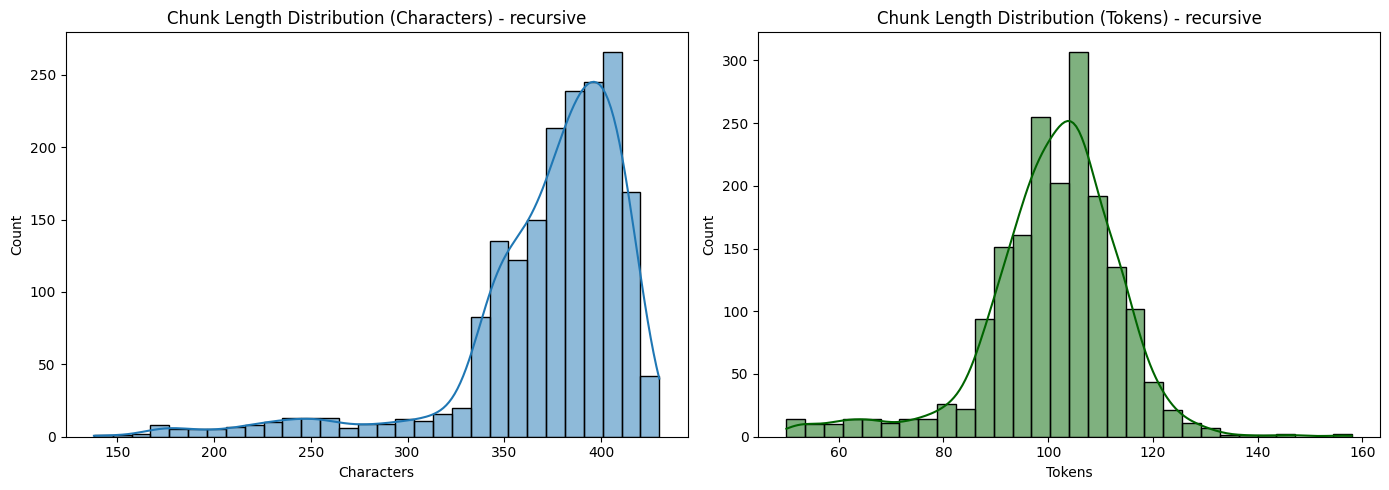

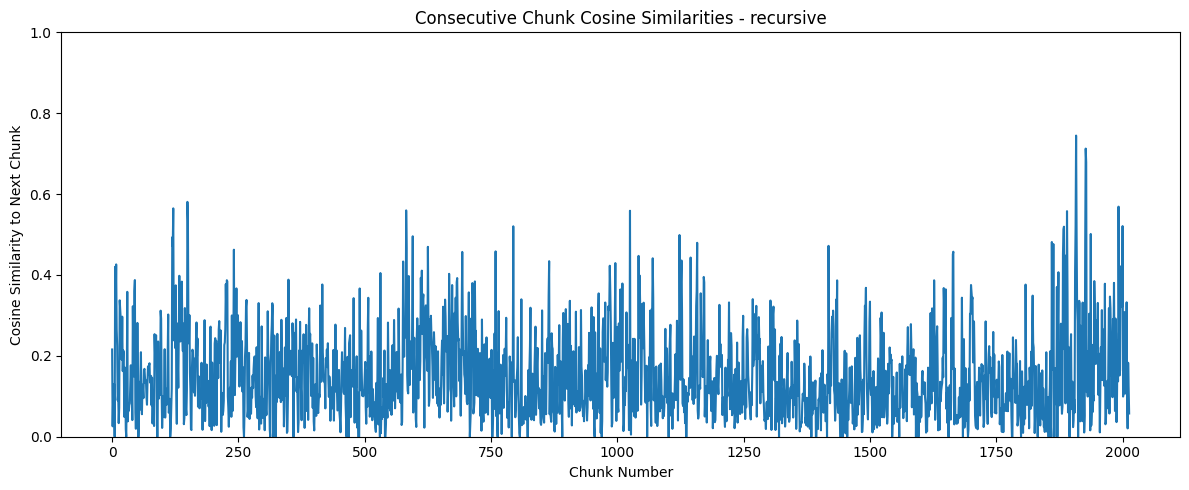


Splitter: TOKEN
[INFO] Split and re-split produced 2054 chunks.
[INFO] Preprocessed 2054 chunks.
[INFO] Filtered out 165 chunks; 1889 remaining.
Stats: {'num_chunks': 1889, 'min_chars': 71, 'max_chars': 540, 'mean_chars': 391.68290100582317, 'median_chars': 406.0, 'std_chars': 63.93738275495379, 'min_tokens': 50, 'max_tokens': 128, 'mean_tokens': 105.76283748014822, 'median_tokens': 110.0, 'std_tokens': 14.183993827009772}
Time spent: 0.494 seconds


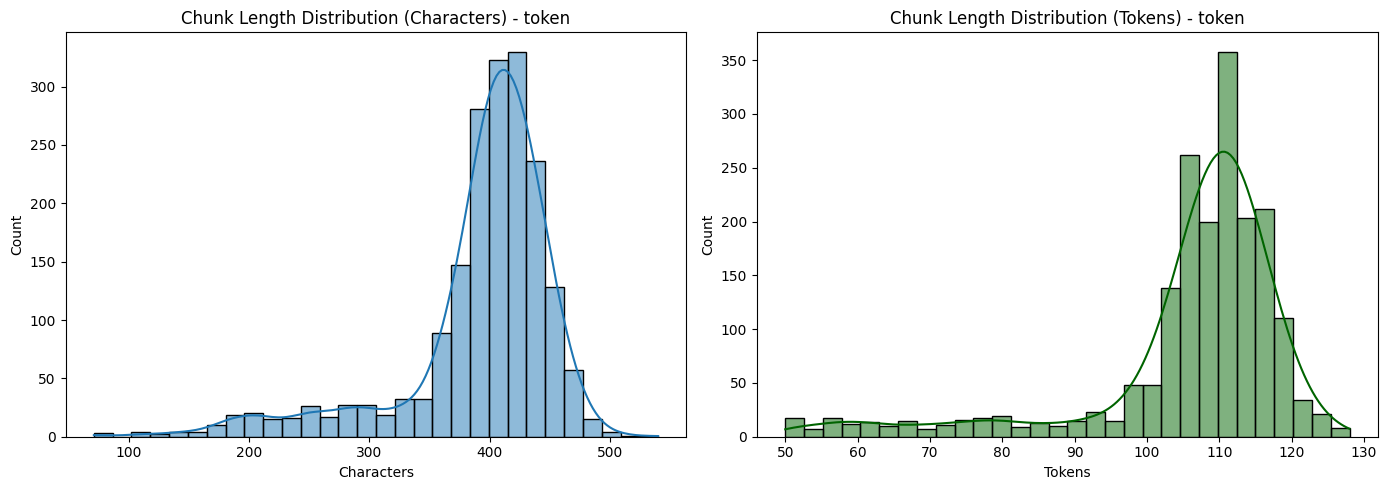

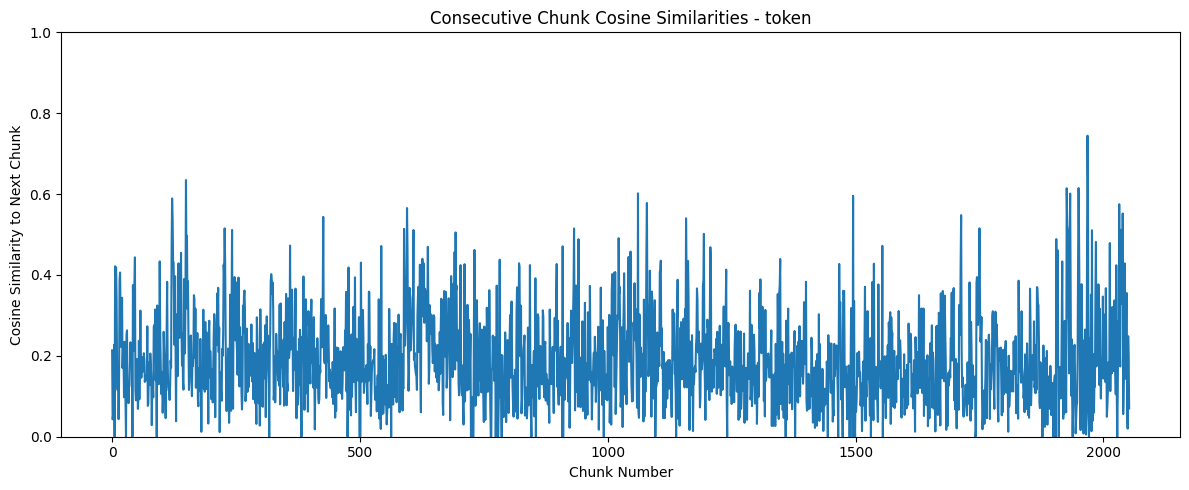


Splitter: NLTK
[INFO] Split and re-split produced 381 chunks.
[INFO] Preprocessed 381 chunks.
[INFO] Filtered out 8 chunks; 373 remaining.
Stats: {'num_chunks': 373, 'min_chars': 170, 'max_chars': 3352, 'mean_chars': 1850.7828418230563, 'median_chars': 1892.0, 'std_chars': 890.1814367733347, 'min_tokens': 51, 'max_tokens': 931, 'mean_tokens': 500.3485254691689, 'median_tokens': 494.0, 'std_tokens': 238.1437413258604}
Time spent: 0.315 seconds


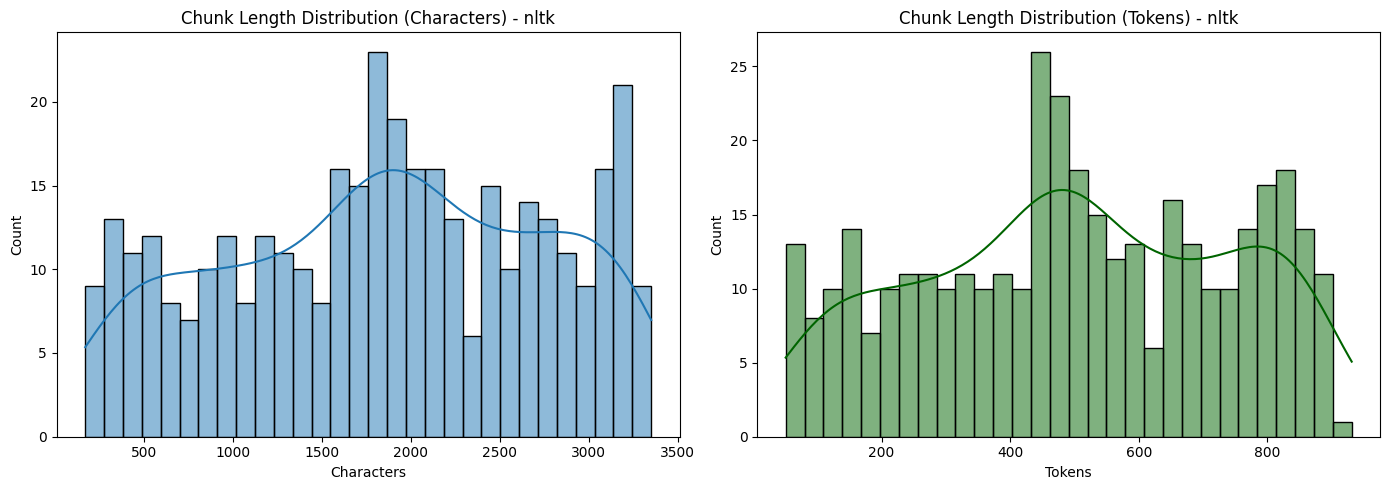

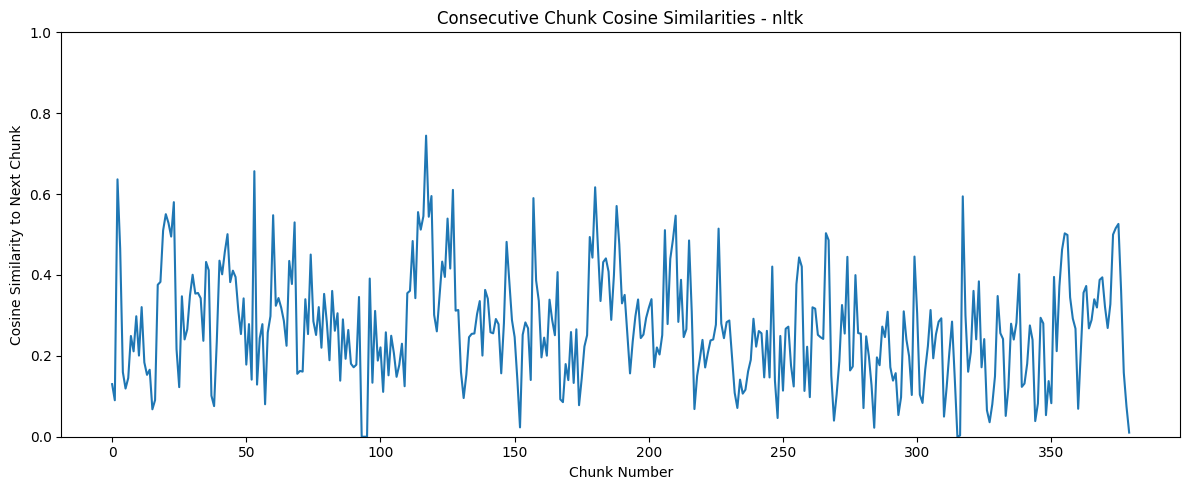


Splitter: SPACY


c:\code\projects\rg1\.venv\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


[INFO] Split and re-split produced 381 chunks.
[INFO] Preprocessed 381 chunks.
[INFO] Filtered out 8 chunks; 373 remaining.
Stats: {'num_chunks': 373, 'min_chars': 170, 'max_chars': 3352, 'mean_chars': 1851.5630026809652, 'median_chars': 1892.0, 'std_chars': 888.1958394677495, 'min_tokens': 51, 'max_tokens': 931, 'mean_tokens': 500.60857908847186, 'median_tokens': 494.0, 'std_tokens': 237.57374389226823}
Time spent: 20.618 seconds


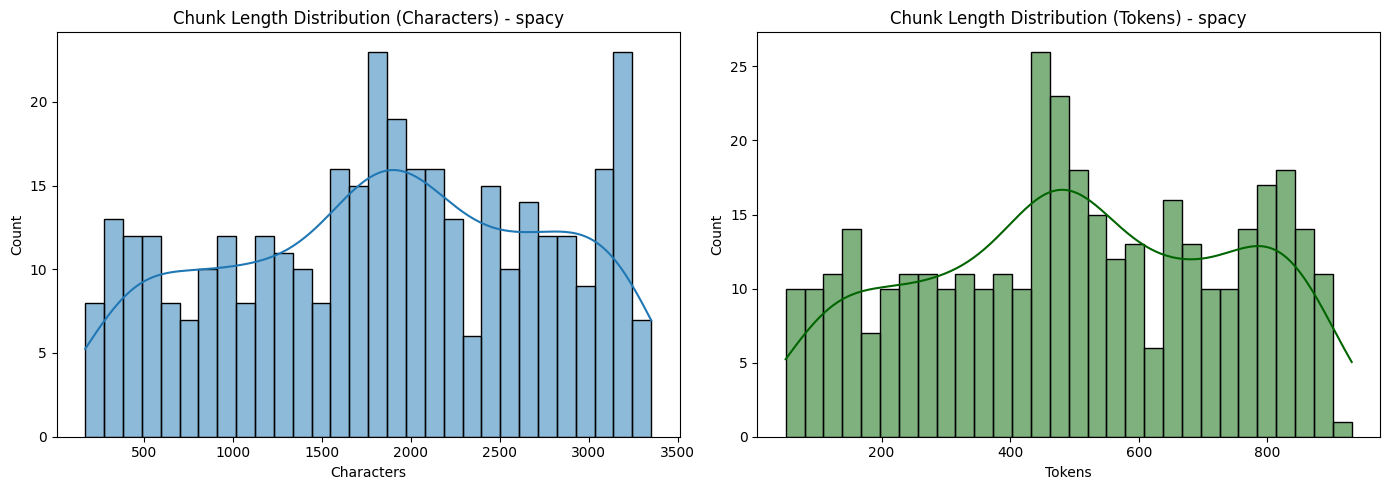

c:\code\projects\rg1\.venv\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


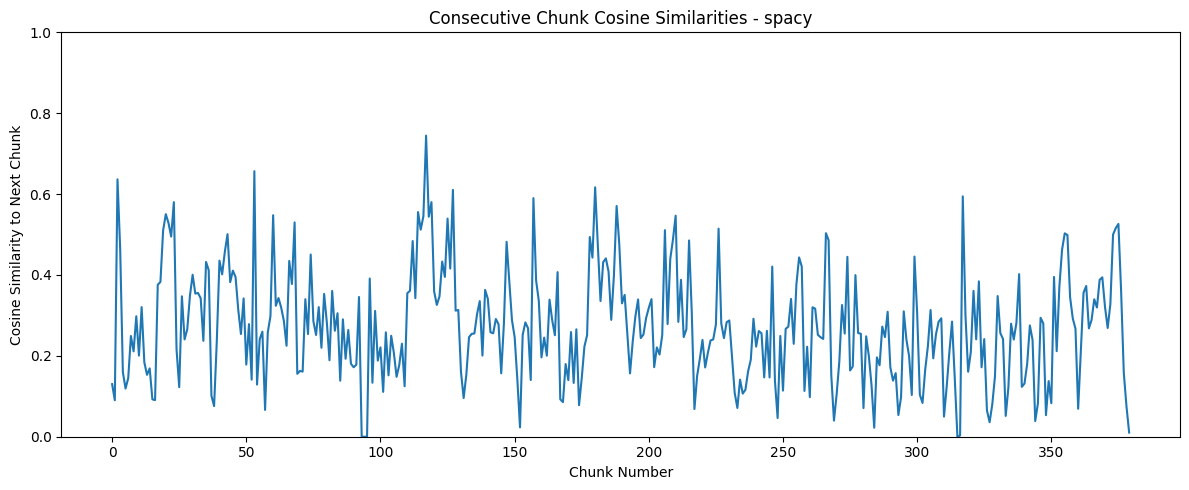

In [9]:
import time
import tiktoken

# Get tokenizer for GPT-3.5-turbo (used for stats and visualization)
tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")

split_methods = ["recursive", "token", "nltk", "spacy"]

for method in split_methods:
    print(f"\nSplitter: {method.upper()}")
    try:
        start_time = time.time()

        # Call the full cleaning + chunking pipeline
        chunks = clean_and_prepare_chunks(
            documents=documents,
            method=method,
            model_name="gpt-3.5-turbo",
            preprocess=True,
            min_tokens=50,
            max_tokens=1000,
            chunk_size=4000,
            chunk_overlap=200
        )

        elapsed = time.time() - start_time

        # Display chunk statistics
        stats = get_chunk_statistics(chunks, tokenizer=tokenizer)
        print(f"Stats: {stats}")
        print(f"Time spent: {elapsed:.3f} seconds")

        # Visualize character and token distributions
        visualize_chunk_distributions(chunks, tokenizer=tokenizer, method_name=method)

        # Compute cosine similarity between consecutive chunks (optional insight)
        df_sim = chunk_consecutive_cosine_similarities(method, documents)
        plot_chunk_similarities(df_sim, method_name=method)

    except Exception as e:
        print(f"❌ Failed to process with {method}: {str(e)}")



Splitter: RECURSIVE
Stats: {'num_chunks': 2015, 'min_chars': 3, 'max_chars': 500, 'mean_chars': 422.6600496277916, 'median_chars': 458.0, 'std_chars': 101.94891956511267, 'min_tokens': 3, 'max_tokens': 297, 'mean_tokens': 130.22630272952853, 'median_tokens': 138.0, 'std_tokens': 33.759702628517374}
Time spent: 0.022 seconds


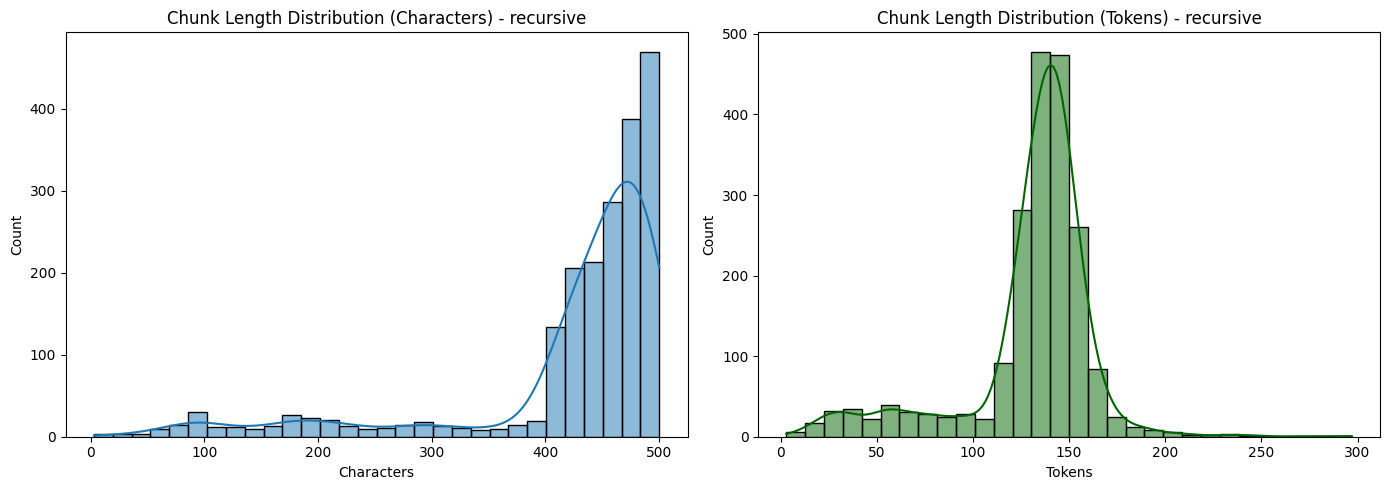

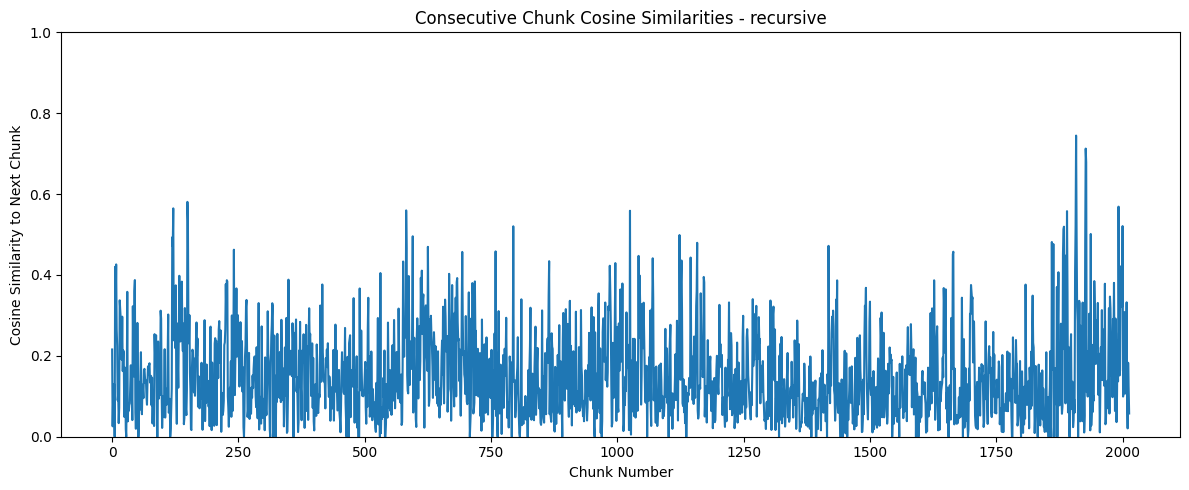


Splitter: TOKEN
Stats: {'num_chunks': 2054, 'min_chars': 3, 'max_chars': 628, 'mean_chars': 446.5111976630964, 'median_chars': 487.0, 'std_chars': 113.59300425040186, 'min_tokens': 3, 'max_tokens': 190, 'mean_tokens': 137.7370983446933, 'median_tokens': 149.0, 'std_tokens': 33.02719390218681}
Time spent: 0.472 seconds


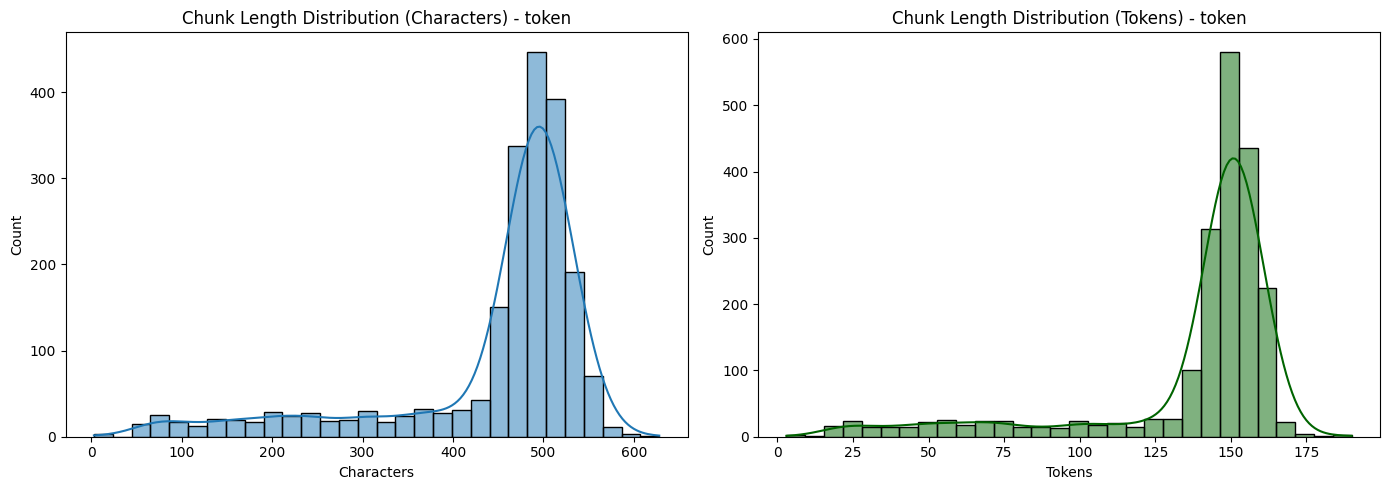

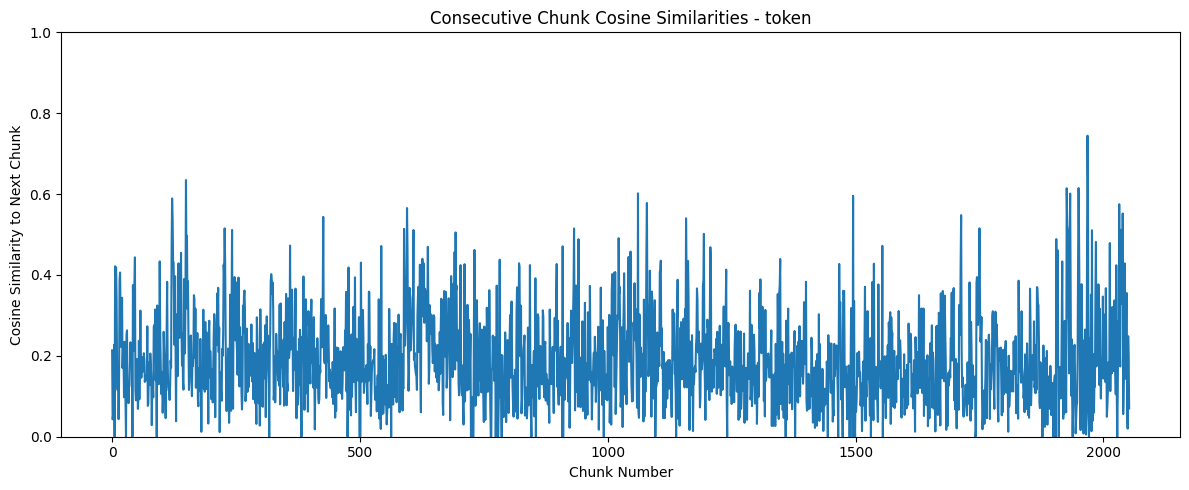


Splitter: NLTK
Stats: {'num_chunks': 381, 'min_chars': 3, 'max_chars': 3982, 'mean_chars': 2208.3648293963256, 'median_chars': 2280.0, 'std_chars': 1109.808524650852, 'min_tokens': 3, 'max_tokens': 1411, 'mean_tokens': 670.8005249343832, 'median_tokens': 687.0, 'std_tokens': 338.29569308185063}
Time spent: 0.219 seconds


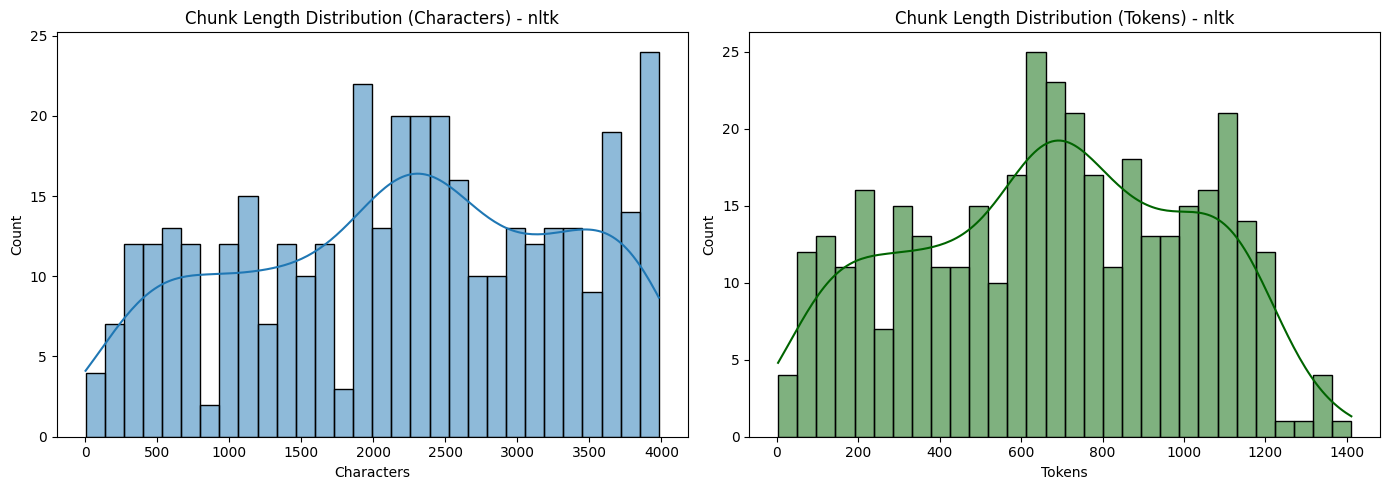

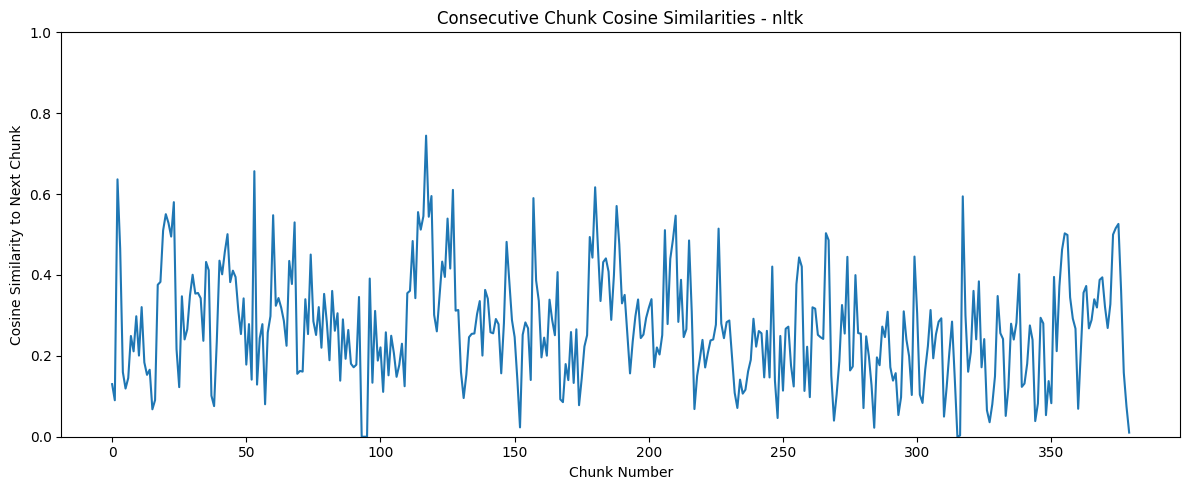


Splitter: SPACY


c:\code\projects\rg1\.venv\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Stats: {'num_chunks': 381, 'min_chars': 3, 'max_chars': 3994, 'mean_chars': 2224.6561679790025, 'median_chars': 2286.0, 'std_chars': 1114.8606258689356, 'min_tokens': 3, 'max_tokens': 1418, 'mean_tokens': 679.8897637795276, 'median_tokens': 696.0, 'std_tokens': 341.8669192429236}
Time spent: 19.781 seconds


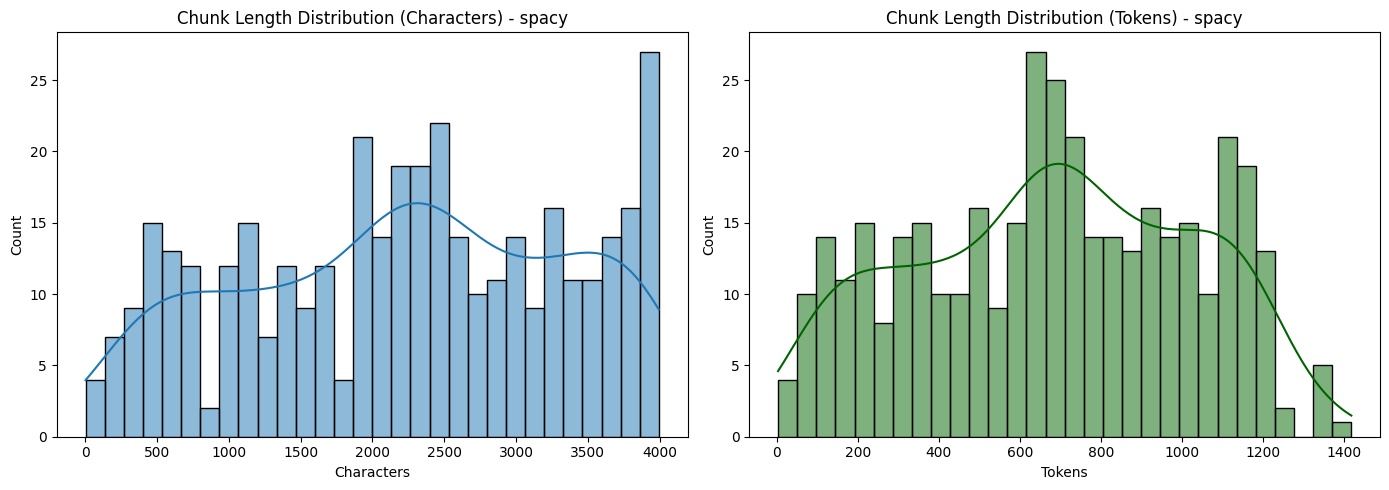

c:\code\projects\rg1\.venv\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


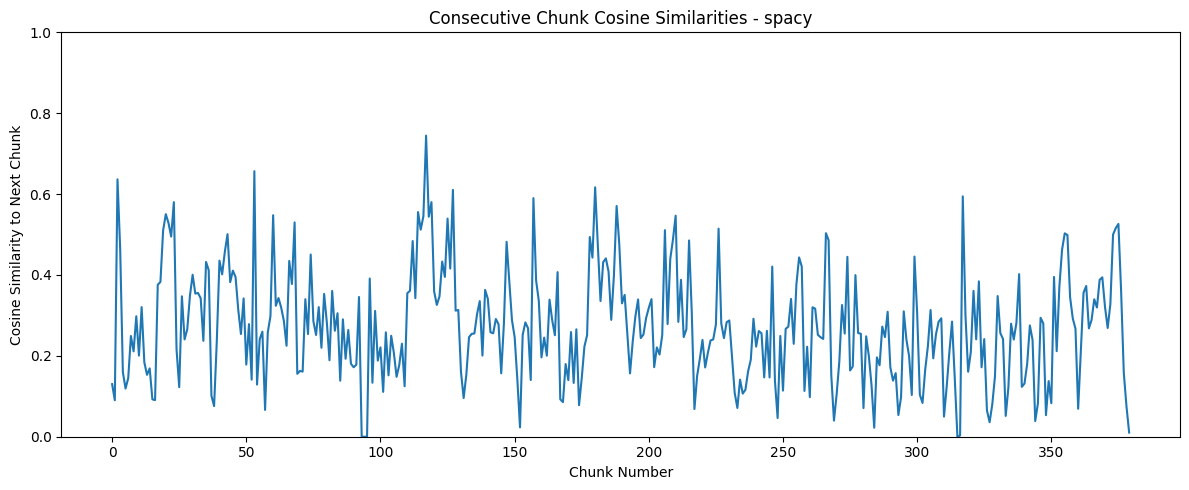

In [5]:
import time
import tiktoken

# Get tokenizer for GPT-3.5 / GPT-4
tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")

split_methods = ["recursive", "token", "nltk", "spacy"]

for method in split_methods:
    print(f"\nSplitter: {method.upper()}")
    try:
        start_time = time.time()
        chunks = split_documents(method, documents)
        elapsed = time.time() - start_time
        stats = get_chunk_statistics(chunks, tokenizer=tokenizer)
        print(f"Stats: {stats}")
        print(f"Time spent: {elapsed:.3f} seconds")
        visualize_chunk_distributions(chunks, tokenizer=tokenizer, method_name=method)
        df_sim = chunk_consecutive_cosine_similarities(method, documents)
        plot_chunk_similarities(df_sim, method_name=method)
    except Exception as e:
        print(f"❌ Failed to split with {method}: {str(e)}")